# **GNN_Energy.ipynb: Energy prediction for EIC Det2 KLM**
This notebook walks through the steps of loading data, training and testing a GNN for energy prediction tasks

In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import matplotlib.pyplot as plot
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot
from datetime import datetime as datetime
current_date = datetime.now().strftime("%B_%d")
from torch.utils.data.sampler import SubsetRandomSampler
from scipy.spatial import ConvexHull
from GNN_util import process_df_vectorized,create_directory,HitDataset,create_fast_edge_lists,visualize_detector_graph,GIN,train_GNN,test_GNN,calculate_bin_rmse

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## **Load in Data**
The data is stored as pandas dataframes where each row is a hit in the detector

In [2]:
num_dfs = 200
dfs = []
for i in range(num_dfs):
    try:
#         new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/Feb_5_50events_run_4_{i}.csv")
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/jan_18_50events_{i}.csv")
    except FileNotFoundError as e:
        # Skip files that failed for some reason...
        # I think these files fail due to DCC issues?
        print(f"skipping file #{i}...")
        continue
    new_df["file_idx"] = i
    dfs.append(new_df)
data = pd.concat(dfs)

skipping file #110...
skipping file #128...


## **Isolate hits in one section of detector**

Because we sometimes get backscattering and other weird detector effects, we want to train the GNN on a cluster of events that are all together, and treat hits that are far away as noise. This implementation allows the user to set how far away the hits can be and still be clustered together

In [3]:
# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 40)

## **Define the dataset class for easy management**

The HitDataset class inherits from the DGLDataset. The required member functions are the init method, process, getitem, and len.

In [122]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,connection_mode = "kNN",max_distance = 200,k = 10):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        self.event_data = torch.tensor([])
        self.connection_mode = connection_mode
        self.k = k
        self.dfs = []
        super().__init__(name = "KLM_reco")
    def get_max_distance_edges(self,curr_event):
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values

        # Create coordinate matrices
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

        # Compute distances in one go
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Create mask for valid edges (upper triangle only to avoid duplicates)
        upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

        # Get edge indices for upper triangle
        src_upper, dst_upper = np.where(upper_mask)

        # Create the bidirectional edges
        sources = np.concatenate([src_upper, dst_upper])
        destinations = np.concatenate([dst_upper, src_upper])
        return sources,destinations
    def get_knn_edges(self,curr_event):
        """ 
        Given x and y coordinates of nodes, compute edges for a k-NN graph.

        Args:
            x (numpy array): x-coordinates of nodes.
            y (numpy array): y-coordinates of nodes.
            k (int): Number of nearest neighbors.

        Returns:
            sources (numpy array): List of source nodes.
            destinations (numpy array): List of destination nodes.
        """
        x = curr_event['strip_x'].values
        y = curr_event['strip_y'].values
        n = len(x)

        # The first notation with "np.newaxis" is the same as tensor.unsqueeze(-1)
        # It puts each value in its own dimension, like
        # x = np.arrayy([[a],[b],[c]]), so size is (N,1) rather than (N)
        # The second notation (x[np.newaxis,:]) just puts the array in another array so that the size is (1,N
        # rather than (N)
        x_diff = x[:, np.newaxis] - x[np.newaxis, :]
        y_diff = y[:, np.newaxis] - y[np.newaxis, :]
        
        # distances has shape (N,N) - matrix where the diagonal is 0, each entry is the distance between
        # the ith (column idx) node and the jth (row idx) node
        distances = np.sqrt(x_diff**2 + y_diff**2)

        # Get the indices of the k nearest neighbors for each node (excluding self-connections)
        # argsort sorts each row by the distance and returns the sorted indices
        # We use the [:,1:k+1] to take the first k indices besides the lowest (which is the diagonal self connection)
        knn_indices = np.argsort(distances, axis=1)[:, 1:self.k+1]

        # Create source and destination lists
        sources = np.concatenate([np.repeat(np.arange(n), self.k),knn_indices.flatten()])
        destinations = np.concatenate([knn_indices.flatten(),np.repeat(np.arange(n), self.k)])

        return sources, destinations
        
    def process(self):
        events_group = self.data.groupby(["event_idx","file_idx"])
        self.labels = torch.tensor([])
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
                # Remove rows that are hits outside of the cone
                curr_event = curr_event[curr_event.ModifiedTrueID != -1]
                nhits = len(curr_event)
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
                continue;
            elif(nhits <self.k):
                sources = np.concatenate([np.repeat(np.arange(nhits),nhits),np.tile(np.arange(nhits),nhits)])
                destinations = np.concatenate([np.tile(np.arange(nhits),nhits),np.repeat(np.arange(nhits),nhits)])
            else:
                if(self.connection_mode == "max distance"):
                    sources, destinations = self.get_max_distance_edges(curr_event)
                elif(self.connection_mode == "kNN"):
                    sources, destinations = self.get_knn_edges(curr_event)
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict momentum/energy
            label = torch.tensor(curr_event["P"].to_numpy()[0])
            '''VERSION LABEL INCLUDING EVENT FEATURES'''
            #THIS VERSION KEEPS FEATURES IN ONE DIMENSION
            feats = np.stack((
                curr_event["strip_x"].to_numpy() / 300,curr_event["strip_y"].to_numpy() / 300,
                curr_event["Time"].to_numpy() / 5,
                curr_event["Charge"].to_numpy(),
                curr_event["stave_idx"].to_numpy(),
                curr_event["layer_idx"].to_numpy(),
                curr_event["segment_idx"].to_numpy(),
                curr_event["SiPM_idx"].to_numpy()
                #,label * np.ones(len(curr_event["strip_x"].to_numpy()))
            ),axis = -1)
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
            self.dfs.append(curr_event)
            # Sort hits by time
            event_df = curr_event.sort_values('Time')

            # Basic features
            total_charge = event_df['Charge'].sum()
            max_charge = event_df['Charge'].max()
            n_hits = len(event_df)

            # Timing features
            time_spread = event_df['Time'].max() - event_df['Time'].min()
            mean_time = event_df['Time'].mean()

            # Spatial features
            hit_coords = event_df[['hit_x', 'hit_y', 'hit_z']].values

            # Center of gravity
            cog_x = np.average(hit_coords[:, 0], weights=event_df['Charge'])
            cog_y = np.average(hit_coords[:, 1], weights=event_df['Charge'])
            cog_z = np.average(hit_coords[:, 2], weights=event_df['Charge'])

            # Shower shape features
            if len(hit_coords) >= 4:  # Need at least 4 points for 3D convex hull
                try:
                    hull = ConvexHull(hit_coords)
                    shower_volume = hull.volume
                    shower_area = hull.area
                except:
                    shower_volume = 0
                    shower_area = 0
            else:
                shower_volume = 0
                shower_area = 0

            # Longitudinal profile
            z_sorted = event_df.sort_values('hit_z')
            charge_profile = z_sorted['Charge'].values
            charge_cumsum = np.cumsum(charge_profile)
            shower_depth = np.interp(0.95 * total_charge, charge_cumsum, z_sorted['hit_z'])

            # Layer-wise features
            layer_charges = event_df.groupby('layer_idx')['Charge'].sum().values
            if len(layer_charges) > 0:
                max_layer_charge = np.max(layer_charges)
                charge_assymetry = np.std(layer_charges) / np.mean(layer_charges) if np.mean(layer_charges) > 0 else 0
            else:
                max_layer_charge = 0
                charge_assymetry = 0

            # Radius of gyration
            r_gyr = np.sqrt(np.average(np.sum((hit_coords - np.array([cog_x, cog_y, cog_z]))**2, axis=1),
                                     weights=event_df['Charge']))

            # Feature vector for this event
            event_features = torch.from_numpy(np.stack((label,
                total_charge,
                max_charge,
                n_hits#,
#                 time_spread,
#                 mean_time,
#                 cog_x,
#                 cog_y,
#                 cog_z,
#                 shower_volume,
#                 shower_area,
#                 shower_depth,
#                 max_layer_charge,
#                 charge_assymetry,
#                 r_gyr
                ),axis = -1))
            if(self.labels.shape[0] == 0):
                self.labels = event_features
            else:
                self.labels = torch.vstack((self.labels,event_features))
            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.dim_event_feats = self.labels.shape[1] - 1
        self.labels = torch.tensor(self.labels, dtype = torch.float32)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [123]:
dataset = HitDataset(modified_df,True,max_distance = 0.05)
print("done")

3260
3260
2880
2880
3220
3220
2020
2020
2380
2380
620
620
3340
3340
2080
2080
2340
2340
2700
2700
2680
2680
2640
2640
2020
2020
2280
2280
2940
2940
3120
3120
2080
2080
2460
2460
2060
2060
2240
2240
1420
1420
5060
5060
2080
2080
1760
1760
2160
2160
1900
1900
3580
3580
2040
2040
1880
1880
1280
1280
3260
3260
1460
1460
2160
2160
2300
2300
3460
3460
1860
1860
2380
2380
360
360
2860
2860
1620
1620
1740
1740
3300
3300
1780
1780
2520
2520
3220
3220
2180
2180
1100
1100
3520
3520
2380
2380
1060
1060
3140
3140
1160
1160
2540
2540
1620
1620
4720
4720
2720
2720
3340
3340
2420
2420
3800
3800
2460
2460
2240
2240
2940
2940
2680
2680
2080
2080
2120
2120
2620
2620
3240
3240
2780
2780
2640
2640
4140
4140
1300
1300
2720
2720
1900
1900
4500
4500
3240
3240
2200
2200
2600
2600
2800
2800
2820
2820
1280
1280
1640
1640
500
500
2940
2940
2400
2400
3840
3840
3280
3280
2200
2200
1780
1780
1940
1940
3840
3840
2960
2960
2280
2280
1180
1180
2220
2220
3920
3920
1160
1160
1680
1680
1360
1360
620
620
5120
5120
1180
118


KeyboardInterrupt



In [130]:
dataset[0][0]

Graph(num_nodes=163, num_edges=3260,
      ndata_schemes={'feat': Scheme(shape=(8,), dtype=torch.float64)}
      edata_schemes={})

## **Optionally, we can visualize any of the input graphs below**

In [141]:
def visualize_detector_graph(dataset,graph_idx = 0, max_edges=1000, figsize=(6, 6)):
    """
    Visualizes the detector hits and their connections.
    
    Parameters:
    curr_event (pd.DataFrame): DataFrame containing 'strip_x' and 'strip_y' columns
    sources (np.array): Array of source node indices
    destinations (np.array): Array of destination node indices
    max_edges (int): Maximum number of edges to plot to avoid overcrowding
    figsize (tuple): Figure size in inches
    """
    
    fig, axs = plot.subplots(1,2,figsize = (12,6))
    graph = dataset[graph_idx][0]
    curr_event = dataset.dfs[graph_idx]
    colors = curr_event['ModifiedTrueID'].apply(lambda x: 'red' if x == -1 else 'blue')
    sizes = curr_event['Charge'].apply(lambda x: x)
    # Create figure
    
    # Plot nodes (hits)
    axs[0].scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c=colors, s=sizes * 1, alpha=0.4, label='Detector hits')
    axs[1].scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c=colors, s=sizes * 1, alpha=0.4, label='Detector hits')
    sources,destinations = graph.edges()
    
    # Plot edges
    for src, dst in zip(sources, destinations):
        x1, y1 = curr_event.iloc[int(src)][['strip_x', 'strip_y']]
        x2, y2 = curr_event.iloc[int(dst)][['strip_x', 'strip_y']]
        axs[0].plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
        axs[1].plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
    # Add reference angle and highlight region
    reference_angle = curr_event['reference_angle'].iloc[0]  # Assuming one reference angle per event
    radius = 250  # Radius of the detector
    
    # Calculate the coordinates for the line
    x_ref = radius * np.cos(np.radians(reference_angle))
    y_ref = radius * np.sin(np.radians(reference_angle))
#     plot.plot([0, x_ref], [0, y_ref], color='black', linewidth=3, label='Reference angle')
    
    # Highlight the 11-degree region
    theta_min = reference_angle - 40
    theta_max = reference_angle + 40
    
    # Calculate the coordinates for the line
    x_min = radius * np.cos(np.radians(theta_min))
    y_min = radius * np.sin(np.radians(theta_min))
    axs[0].plot([0, x_min], [0, y_min], color='orange', linewidth=1.5, label='Lower bound')
    
    # Calculate the coordinates for the line
    x_max = radius * np.cos(np.radians(theta_max))
    y_max = radius * np.sin(np.radians(theta_max))
    axs[0].plot([0, x_max], [0, y_max], color='orange', linewidth=1.5, label='Upper bound')
    
    # Add labels and title
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Y Position')
    n_edges = len(sources) / 2
    fig.suptitle(f'Detector Graph Visualization\n{len(curr_event)} nodes, {n_edges//2} edges')
    
    # Add text with statistics
    stats_text = f'Total nodes: {len(curr_event)}\n'
    stats_text += f'Total edges: {n_edges//2}\n'  # Divide by 2 because edges are bidirectional
    stats_text += f'Average degree: {n_edges/len(curr_event):.1f}'
    axs[1].text(0.02, 0.98, stats_text,
             transform=plot.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axs[0].grid(True, alpha=0.3)
    axs[0].axis('equal')
    fig.tight_layout()
    axs[0].set_xlim(-250,250)
    axs[0].set_ylim(-250,250)

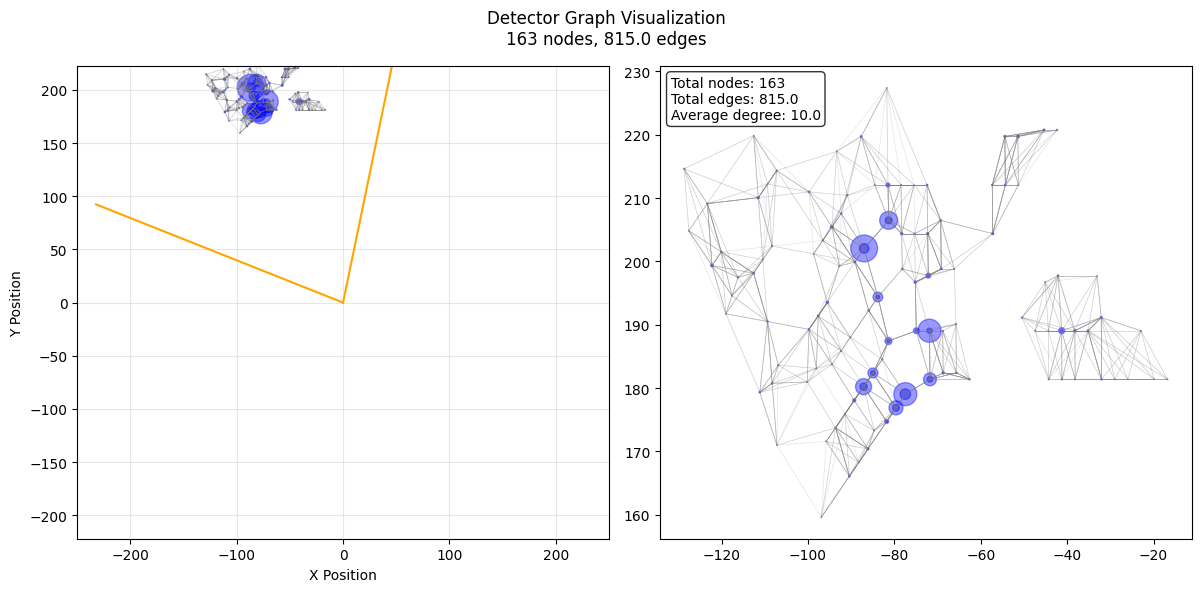

In [142]:
visualize_detector_graph(dataset,graph_idx = 0)

## **Define dataloader**

We use a dataloader to make batching easier, and to randomly split test and train

In [197]:
train_frac = 0.7
val_frac = 0.15
num_train = int(np.floor(len(dataset) * train_frac))
# num_train = 5
num_val = int(np.floor(len(dataset) * val_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
val_sampler = SubsetRandomSampler(torch.arange(num_train, num_val + num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_val + num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

## **Initialize the model and define the optimizer/criterion**

In [198]:
run_num = 1
geometry_type = 2

In [199]:

from dgl.nn import GraphConv,SumPooling,GINConv,AvgPooling

In [200]:
# #TESTING EVENT LEVEL FEATURES
# class GIN(nn.Module):
#     def __init__(self, in_feats, h_feats,num_event_feats, num_classes=1):
#         super(GIN, self).__init__()
        
#         # Define the MLP for the GINConv layers
#         self.mlp1 = nn.Sequential(
#             nn.Linear(in_feats, h_feats),
#             nn.ReLU(),
#             nn.Linear(h_feats, h_feats)
#         )
        
#         self.mlp2 = nn.Sequential(
#             nn.Linear(h_feats, h_feats),
#             nn.ReLU(),
#             nn.Linear(h_feats, h_feats)
#         )
        
#         # Define the GINConv layers
#         self.conv1 = GINConv(self.mlp1)
#         self.conv2 = GINConv(self.mlp2)
#         self.linear1 = nn.Linear(h_feats + num_event_feats, 256)
#         self.linear2 = nn.Linear(256, 128)
#         self.linear3 = nn.Linear(128, 128)
#         self.linear4 = nn.Linear(128, 64)
#         self.linear5 = nn.Linear(64, 64)
#         self.linear6 = nn.Linear(64, 16)
#         self.linear7 = nn.Linear(16, 1)
        
#         # Graph pooling layer
#         self.pool = AvgPooling()
# #         self.pool = SumPooling()

#     def forward(self, g, in_feat,event_feats):
#         # Apply the first GINConv layer
#         h = self.conv1(g, in_feat)
#         h = F.relu(h)
        
# #         Apply the second GINConv layer
#         h = self.conv2(g, h)
#         h = F.relu(h)
        
#         # Pool the graph-level representation
#         hg = self.pool(g, h)
#         total_feats = torch.cat((hg,event_feats),axis = 1).float()
#         hg = self.linear1(total_feats)
#         hg = F.relu(hg)
#         hg = self.linear2(hg)
#         hg = F.relu(hg)
#         hg = self.linear3(hg)
#         hg = F.relu(hg)
#         hg = self.linear4(hg)
#         hg = F.relu(hg)
#         hg = self.linear5(hg)
#         hg = F.relu(hg)
#         hg = self.linear6(hg)
#         hg = F.relu(hg)
#         hg = self.linear7(hg)
#         return hg

In [220]:
#TESTING EVENT LEVEL FEATURES
class GIN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes=1):
        super(GIN, self).__init__()
        
        # Define the MLP for the GINConv layers
        self.mlp1 = nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        )
        
        self.mlp2 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        )
        
        # Define the GINConv layers
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        self.linear1 = nn.Linear(h_feats, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 128)
        self.linear4 = nn.Linear(128, 64)
        self.linear5 = nn.Linear(64, 64)
        self.linear6 = nn.Linear(64, 16)
        self.linear7 = nn.Linear(16, 1)
        
        # Graph pooling layer
        self.pool = AvgPooling()
#         self.pool = SumPooling()

    def forward(self, g, in_feat):
        # Apply the first GINConv layer
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        
#         Apply the second GINConv layer
        h = self.conv2(g, h)
        h = F.relu(h)
        
        # Pool the graph-level representation
        hg = self.pool(g, h)
#         total_feats = torch.cat((hg,event_feats),axis = 1).float()
        hg = self.linear1(hg)
        hg = F.relu(hg)
        hg = self.linear2(hg)
        hg = F.relu(hg)
        hg = self.linear3(hg)
        hg = F.relu(hg)
        hg = self.linear4(hg)
        hg = F.relu(hg)
        hg = self.linear5(hg)
        hg = F.relu(hg)
        hg = self.linear6(hg)
        hg = F.relu(hg)
        hg = self.linear7(hg)
        return hg

In [208]:
# hidden_dim = 32
# model = GIN(dataset.dim_nfeats,hidden_dim,dataset.dim_event_feats)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# # criterion = F.smooth_l1_loss
# criterion = nn.MSELoss()

In [225]:
hidden_dim = 32
model = GIN(dataset.dim_nfeats,hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# criterion = F.smooth_l1_loss
criterion = nn.MSELoss()

*Now we can actually train the model*

In [228]:
#TESTING INPUTTING EVENT LEVEL FEATURES
def train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs,early_stopping_limit):
    create_directory(f"models/GNN_Energy_prediction/{current_date}/")
    val_mse = []
    val_mse_all = []
    train_losses = []
    train_losses_all = []
    early_stopping_dict = {
            "lowest_loss" : -1,
            "best_model_path" : "",
            "num_upticks" : 0
    }
    # 0: loss; 1: path; 2: # hits

    for epoch in range(n_epochs):
        model.train()
        num_train_batches = 0
        epoch_train_losses = 0.0
        train_preds = torch.tensor([])
        train_truths = torch.tensor([])
        
        for batched_graph, labels_w_event_feats in train_dataloader:
            labels = labels_w_event_feats[:,0]
            pred = model(batched_graph, batched_graph.ndata["feat"].float())
            loss = criterion(pred, labels.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_train_losses+=loss.detach()
            train_losses_all.append(loss.detach())
            num_train_batches += 1
            train_preds = torch.cat([train_preds,pred.detach()])
            train_truths = torch.cat([train_truths,labels])
#         for batched_graph, labels_w_event_feats in train_dataloader:
#             labels = labels_w_event_feats[:,0]
#             event_feats = labels_w_event_feats[:,1:]
#             pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
#             loss = criterion(pred, labels.unsqueeze(-1))
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             epoch_train_losses+=loss.detach()
#             train_losses_all.append(loss.detach())
#             num_train_batches += 1
#             train_preds = torch.cat([train_preds,pred.detach()])
#             train_truths = torch.cat([train_truths,labels])
        # Average RMSE for the epoch
        this_epoch_loss = epoch_train_losses / num_train_batches
        train_losses.append(this_epoch_loss)
        # Testing phase
        model.eval()
        epoch_val_mse = 0.0
        num_val_batches = 0
        val_preds = torch.tensor([])
        val_truths = torch.tensor([])
#         with torch.no_grad():  # Disable gradients for evaluation
#             for batched_graph, labels_w_event_feats in val_dataloader:
#                 labels = labels_w_event_feats[:,0]
#                 event_feats = labels_w_event_feats[:,1:]
#                 pred = model(batched_graph, batched_graph.ndata["feat"].float(),event_feats)
#                 # Calculate RMSE for this batch
#                 batch_mse = criterion(pred, labels.unsqueeze(-1))
#                 epoch_val_mse += batch_mse
#                 num_val_batches += 1
#                 val_mse_all.append(batch_mse)
#                 val_preds = torch.cat([val_preds,pred])
#                 val_truths = torch.cat([val_truths,labels])
    
        with torch.no_grad():  # Disable gradients for evaluation
            for batched_graph, labels_w_event_feats in val_dataloader:
                labels = labels_w_event_feats[:,0]
                pred = model(batched_graph, batched_graph.ndata["feat"].float())
                # Calculate RMSE for this batch
                batch_mse = criterion(pred, labels.unsqueeze(-1))
                epoch_val_mse += batch_mse
                num_val_batches += 1
                val_mse_all.append(batch_mse)
                val_preds = torch.cat([val_preds,pred])
                val_truths = torch.cat([val_truths,labels])

        # Average RMSE for the test set
        epoch_val_mse /= num_val_batches
        val_mse.append(epoch_val_mse)
        
        if(epoch %1 == 0):
            print(f"Epoch {epoch + 1}/{n_epochs} - Train loss:\t {this_epoch_loss:.4f}")
            print(f"Epoch {epoch + 1}/{n_epochs} - Validation MSE:\t {epoch_val_mse:.4f}\n")
            plot.plot([0,5],[0,5])
            plot.title("Test dataset results")
            plot.scatter(val_truths,val_preds,alpha = 0.05,color = "red",label = "val")
#             plot.scatter(train_truths,train_preds,alpha = 0.01,color = "blue",label = "train")
            plot.xlabel("truths")
            plot.ylabel("preds")
            plot.text(3.1,1.3, f"Epoch #{epoch + 1}\nTrain, val loss: ({this_epoch_loss:.4f},{epoch_val_mse:.4f})")
            plot.tight_layout()
            plot.legend()
            plot.savefig(f"plots/training_gif_full_dataset_no_event_feats/frame{epoch}.jpeg")
            plot.show()
        
        if(epoch_val_mse.item() < early_stopping_dict["lowest_loss"] or early_stopping_dict["lowest_loss"] == -1):
            early_stopping_dict["lowest_loss"] = epoch_val_mse
            early_stopping_dict["best_model_path"] = f"models/GNN_Energy_prediction/{current_date}/run_{run_num}_events50k_lr0_001_hiddendim6_epoch{epoch}_geometry_{geometry_type}pth"
            early_stopping_dict["num_upticks"] = 0
            
            torch.save(model.state_dict(),early_stopping_dict["best_model_path"])
        elif(epoch_val_mse.item() > early_stopping_dict["lowest_loss"]):
            early_stopping_dict["num_upticks"] += 1
            print("Test loss increased, adding uptick")
        if(early_stopping_dict["num_upticks"] >= early_stopping_limit):
            # Stop training, load best model
            model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))
            torch.save(model.state_dict(),f"models/GNN_Energy_prediction/{current_date}/run_{run_num}_events50k_lr0_001_hiddendim6_best_geometry_{geometry_type}.pth")
            print("Stopping early, loading current model...")
            break
    return model, train_losses, val_mse, optimizer

Epoch 1/300 - Train loss:	 0.3366
Epoch 1/300 - Validation MSE:	 0.3675



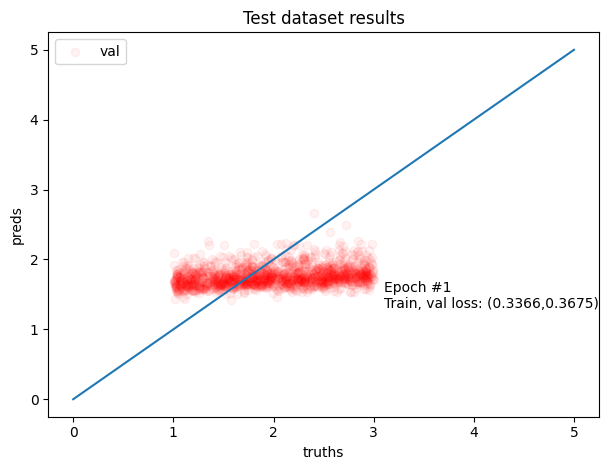

Epoch 2/300 - Train loss:	 0.3222
Epoch 2/300 - Validation MSE:	 0.3267



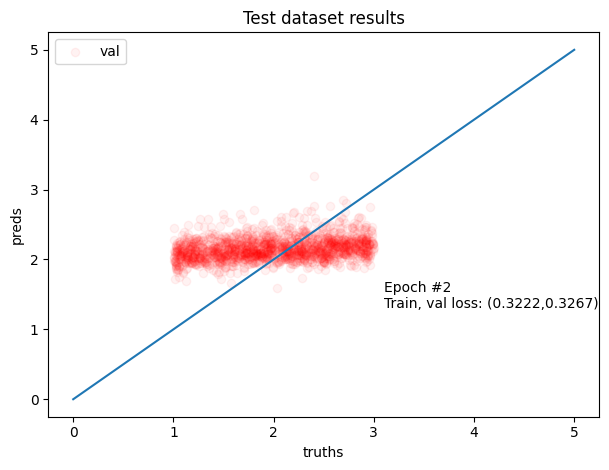

Epoch 3/300 - Train loss:	 0.3167
Epoch 3/300 - Validation MSE:	 0.3043



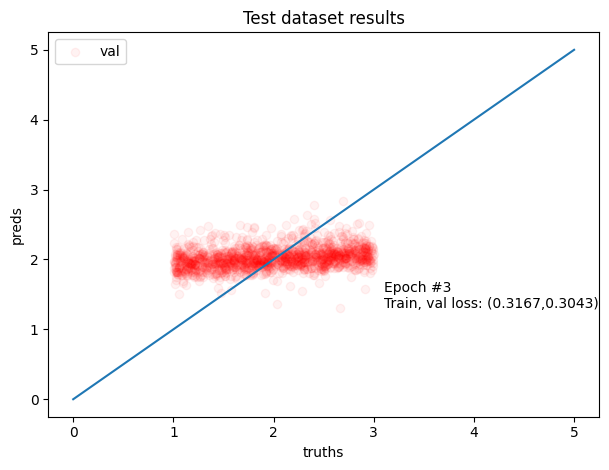

Epoch 4/300 - Train loss:	 0.3131
Epoch 4/300 - Validation MSE:	 0.3114



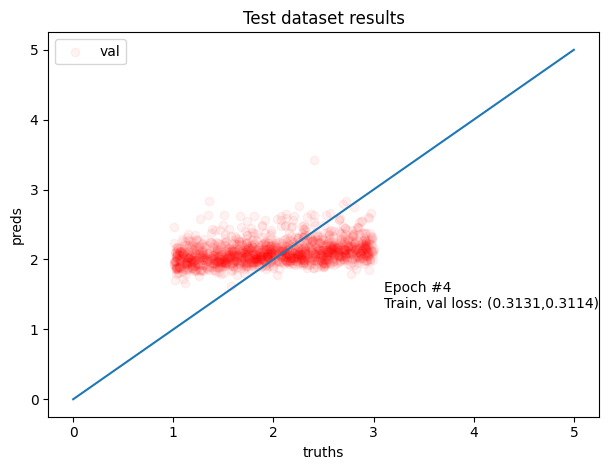

Test loss increased, adding uptick
Epoch 5/300 - Train loss:	 0.3150
Epoch 5/300 - Validation MSE:	 0.3028



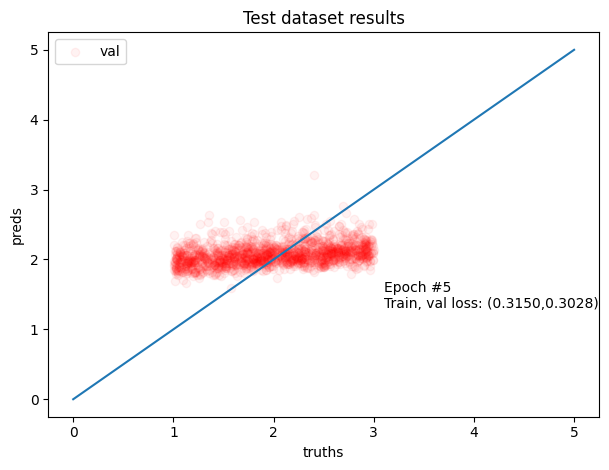

Epoch 6/300 - Train loss:	 0.3097
Epoch 6/300 - Validation MSE:	 0.3253



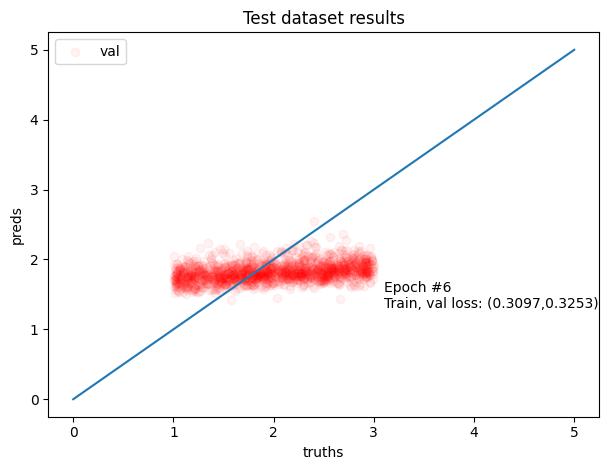

Test loss increased, adding uptick
Epoch 7/300 - Train loss:	 0.3073
Epoch 7/300 - Validation MSE:	 0.3050



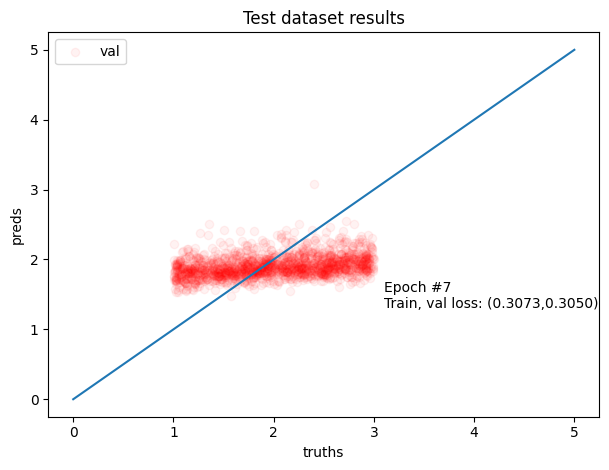

Test loss increased, adding uptick
Epoch 8/300 - Train loss:	 0.3085
Epoch 8/300 - Validation MSE:	 0.2949



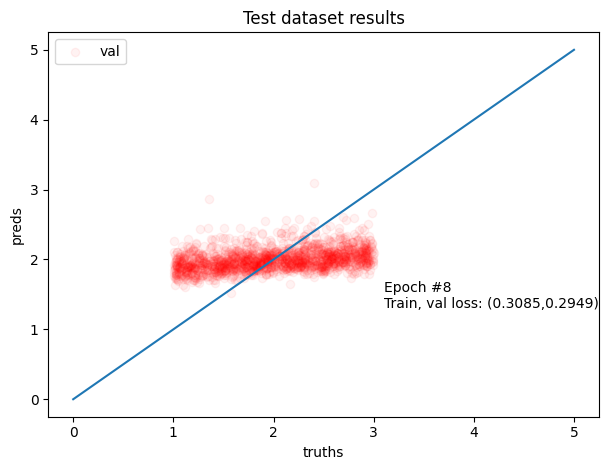

Epoch 9/300 - Train loss:	 0.3070
Epoch 9/300 - Validation MSE:	 0.2926



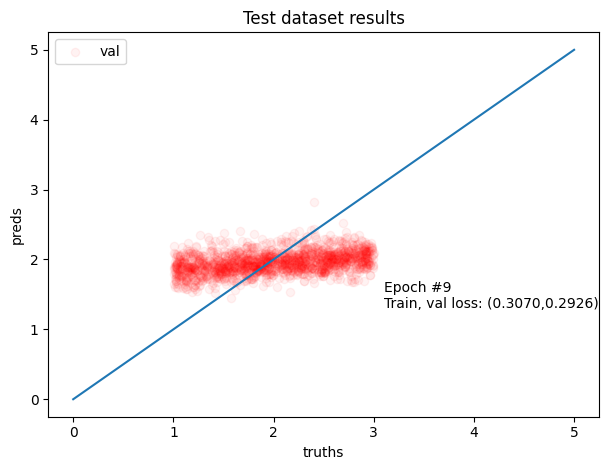

Epoch 10/300 - Train loss:	 0.3006
Epoch 10/300 - Validation MSE:	 0.2877



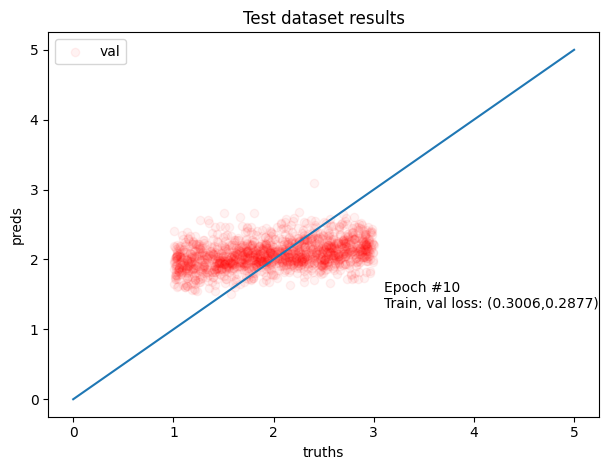

Epoch 11/300 - Train loss:	 0.2994
Epoch 11/300 - Validation MSE:	 0.3140



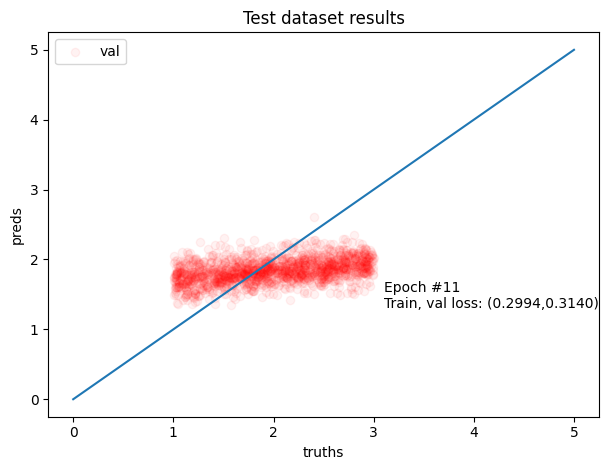

Test loss increased, adding uptick
Epoch 12/300 - Train loss:	 0.2993
Epoch 12/300 - Validation MSE:	 0.2926



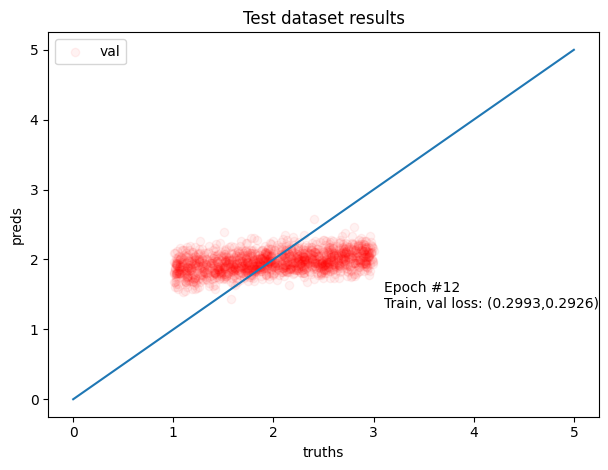

Test loss increased, adding uptick
Epoch 13/300 - Train loss:	 0.2937
Epoch 13/300 - Validation MSE:	 0.2813



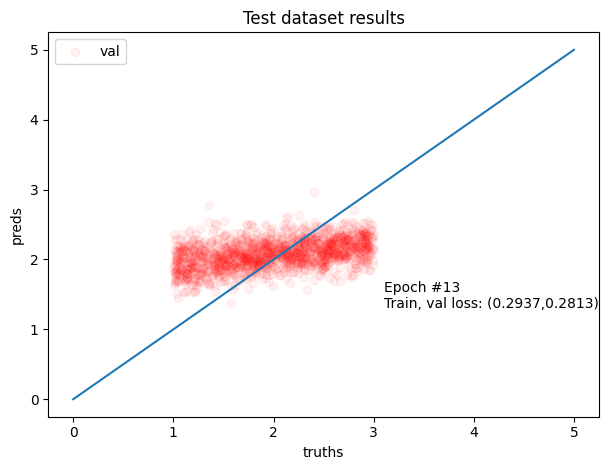

Epoch 14/300 - Train loss:	 0.2900
Epoch 14/300 - Validation MSE:	 0.2798



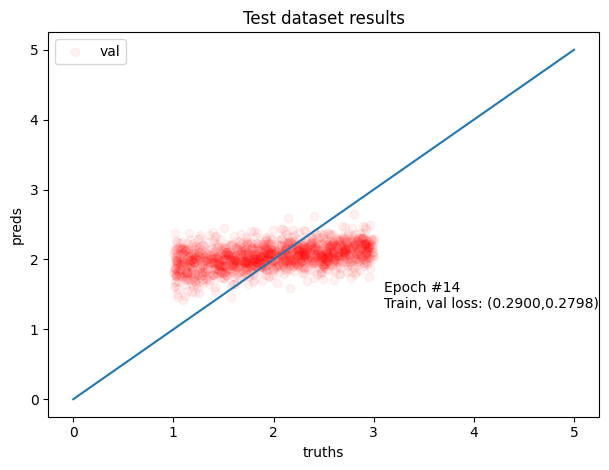

Epoch 15/300 - Train loss:	 0.2855
Epoch 15/300 - Validation MSE:	 0.2901



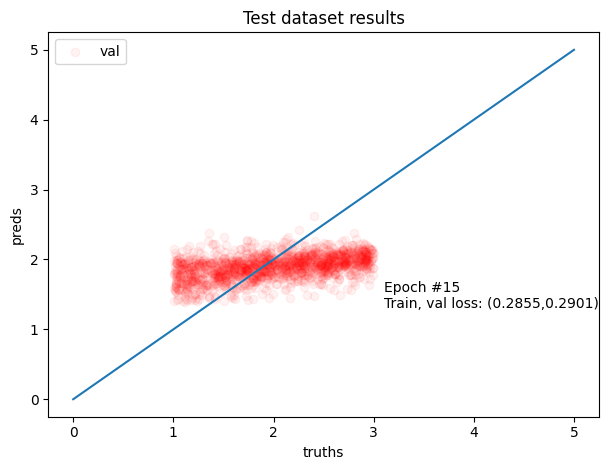

Test loss increased, adding uptick
Epoch 16/300 - Train loss:	 0.2843
Epoch 16/300 - Validation MSE:	 0.2716



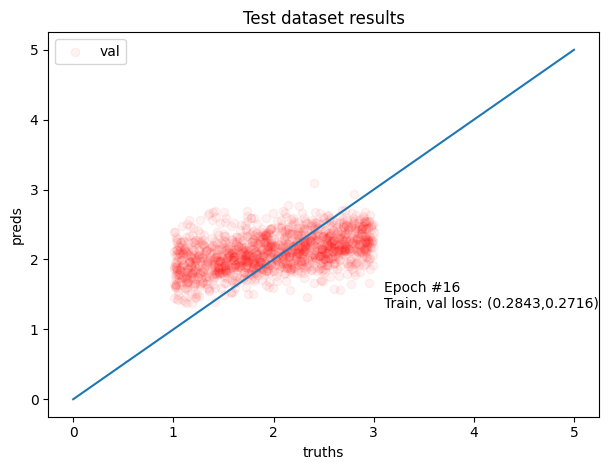

Epoch 17/300 - Train loss:	 0.2790
Epoch 17/300 - Validation MSE:	 0.2666



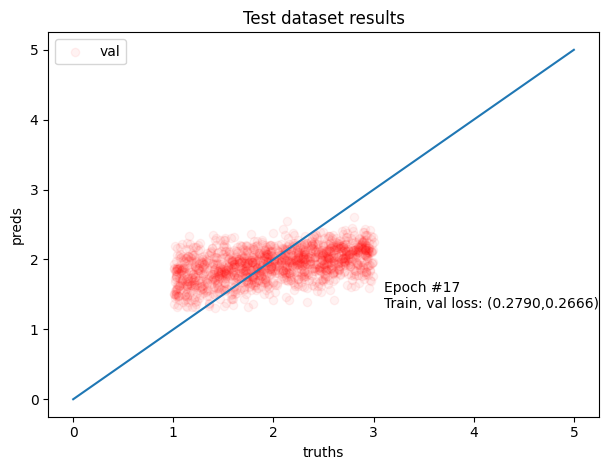

Epoch 18/300 - Train loss:	 0.2752
Epoch 18/300 - Validation MSE:	 0.2691



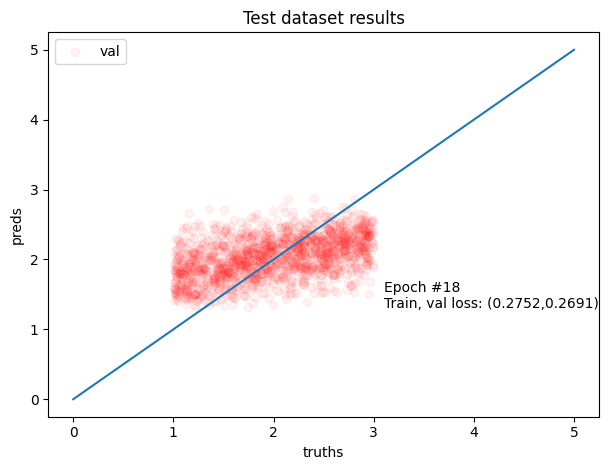

Test loss increased, adding uptick
Epoch 19/300 - Train loss:	 0.2681
Epoch 19/300 - Validation MSE:	 0.2593



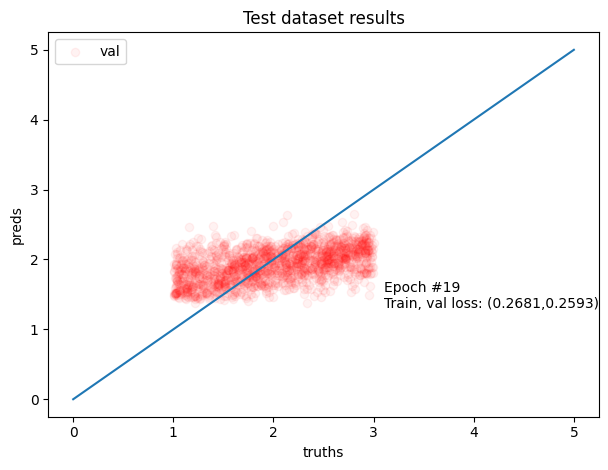

Epoch 20/300 - Train loss:	 0.2645
Epoch 20/300 - Validation MSE:	 0.2592



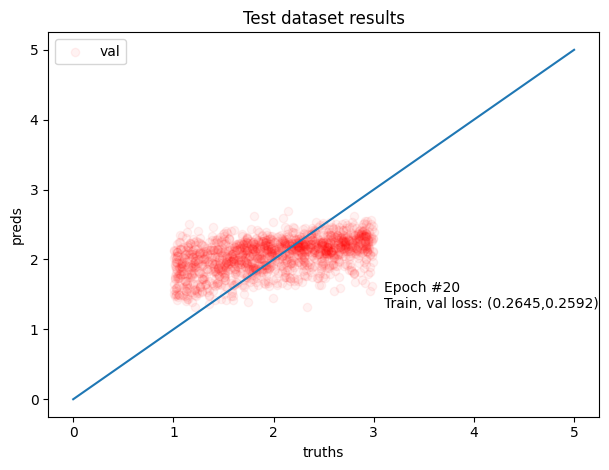

Epoch 21/300 - Train loss:	 0.2645
Epoch 21/300 - Validation MSE:	 0.2661



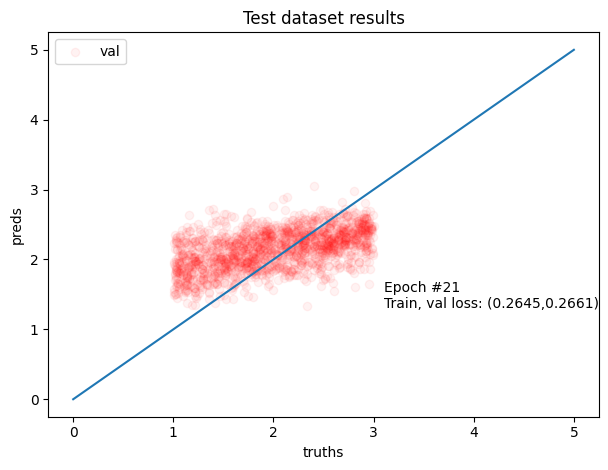

Test loss increased, adding uptick
Epoch 22/300 - Train loss:	 0.2646
Epoch 22/300 - Validation MSE:	 0.2593



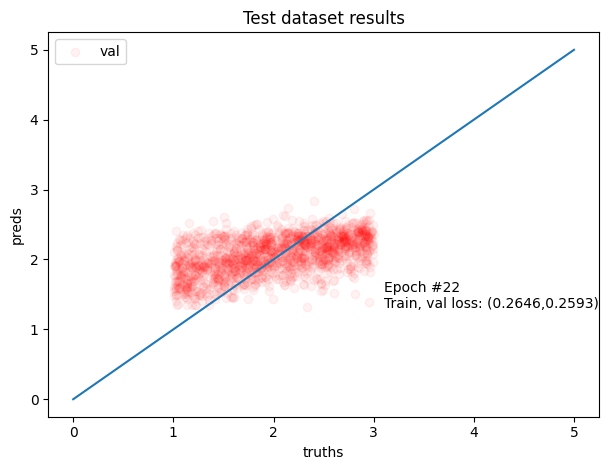

Test loss increased, adding uptick
Epoch 23/300 - Train loss:	 0.2589
Epoch 23/300 - Validation MSE:	 0.2608



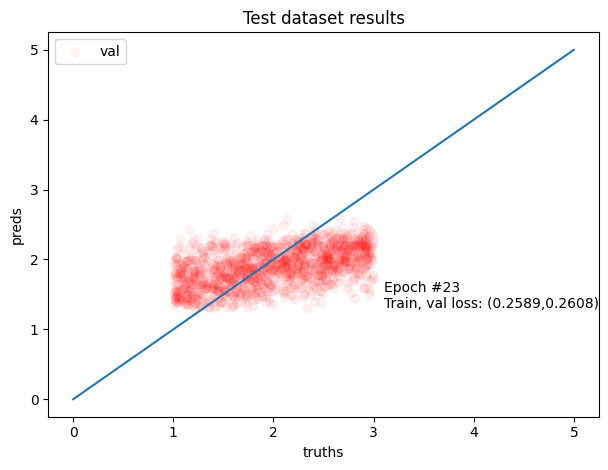

Test loss increased, adding uptick
Epoch 24/300 - Train loss:	 0.2539
Epoch 24/300 - Validation MSE:	 0.2634



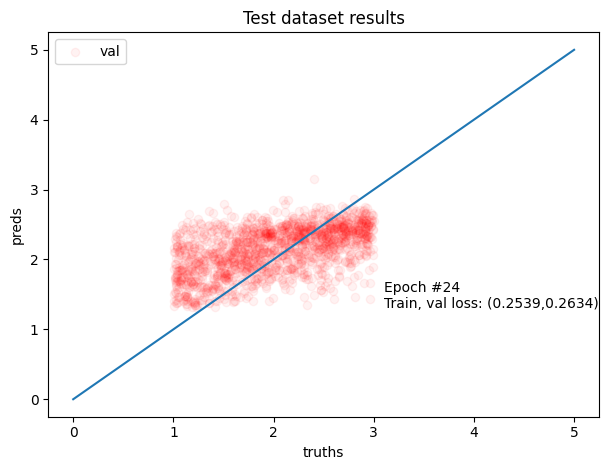

Test loss increased, adding uptick
Epoch 25/300 - Train loss:	 0.2521
Epoch 25/300 - Validation MSE:	 0.2538



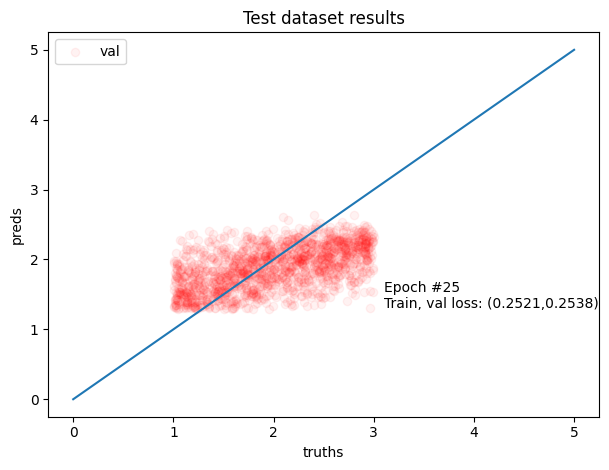

Epoch 26/300 - Train loss:	 0.2475
Epoch 26/300 - Validation MSE:	 0.2485



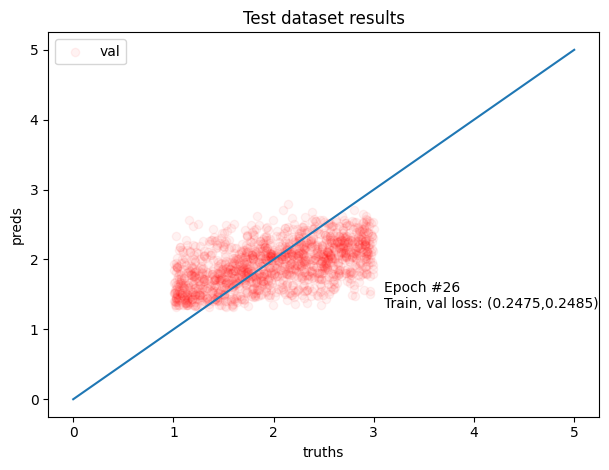

Epoch 27/300 - Train loss:	 0.2463
Epoch 27/300 - Validation MSE:	 0.2359



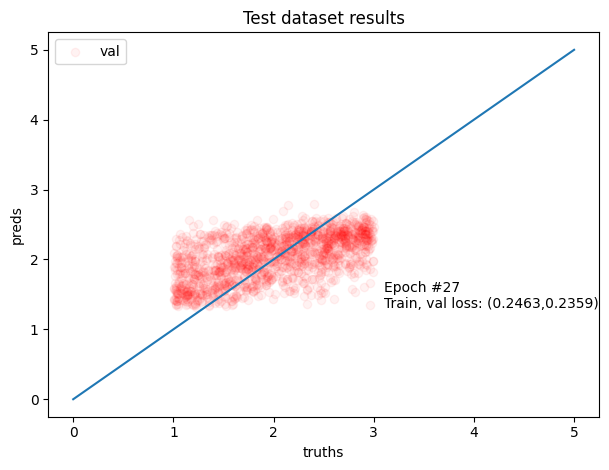

Epoch 28/300 - Train loss:	 0.2444
Epoch 28/300 - Validation MSE:	 0.2379



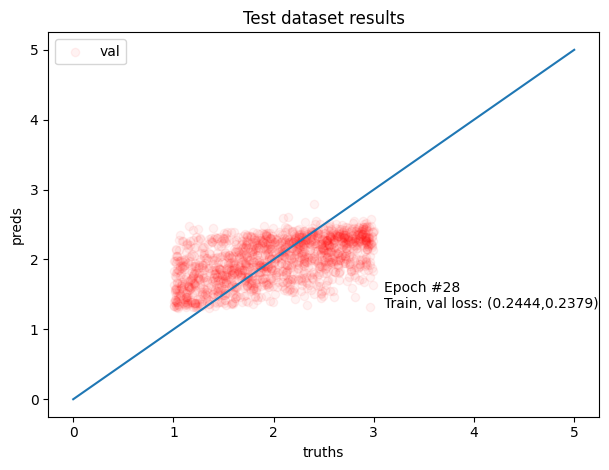

Test loss increased, adding uptick
Epoch 29/300 - Train loss:	 0.2428
Epoch 29/300 - Validation MSE:	 0.2702



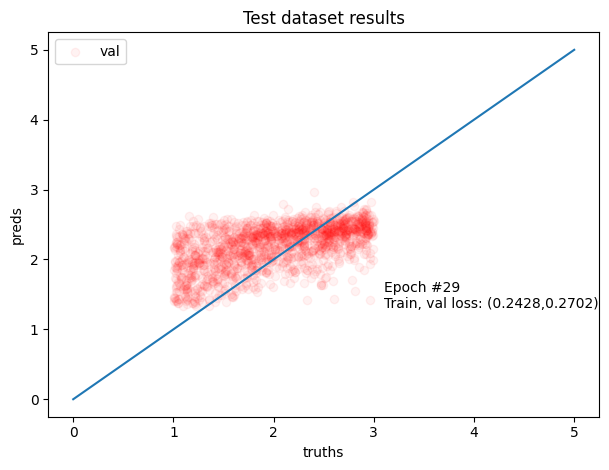

Test loss increased, adding uptick
Epoch 30/300 - Train loss:	 0.2402
Epoch 30/300 - Validation MSE:	 0.2327



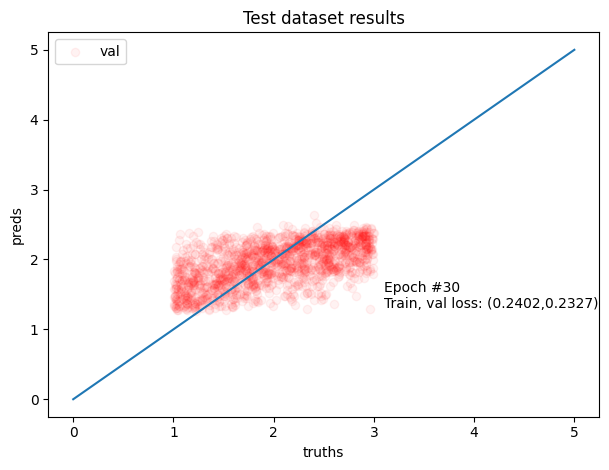

Epoch 31/300 - Train loss:	 0.2406
Epoch 31/300 - Validation MSE:	 0.2329



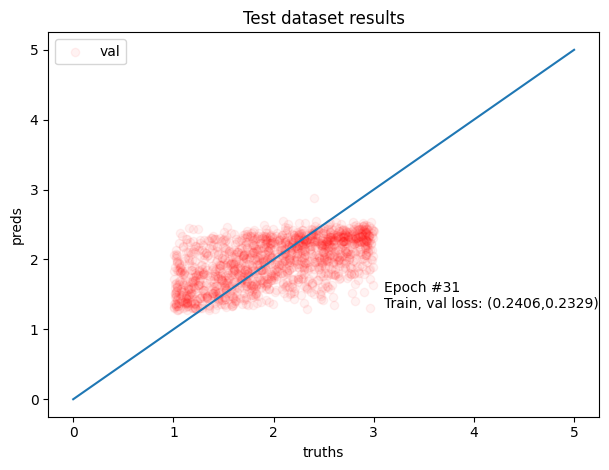

Test loss increased, adding uptick
Epoch 32/300 - Train loss:	 0.2384
Epoch 32/300 - Validation MSE:	 0.2513



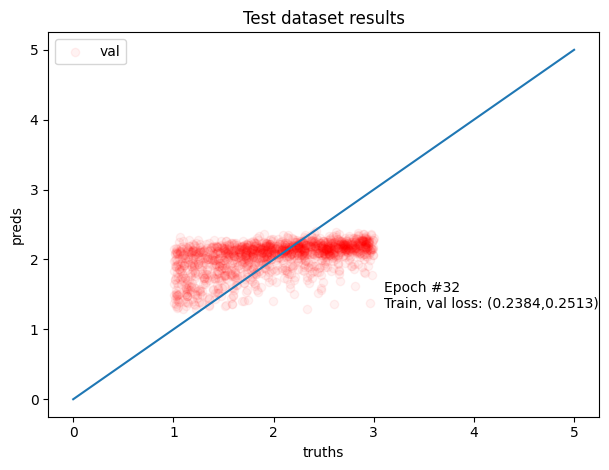

Test loss increased, adding uptick
Epoch 33/300 - Train loss:	 0.2359
Epoch 33/300 - Validation MSE:	 0.2408



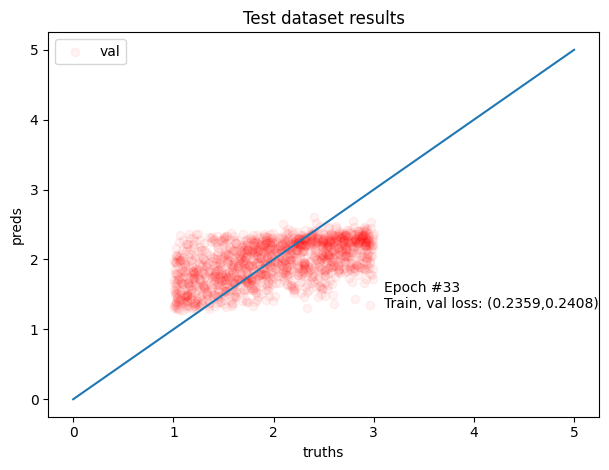

Test loss increased, adding uptick
Epoch 34/300 - Train loss:	 0.2344
Epoch 34/300 - Validation MSE:	 0.2336



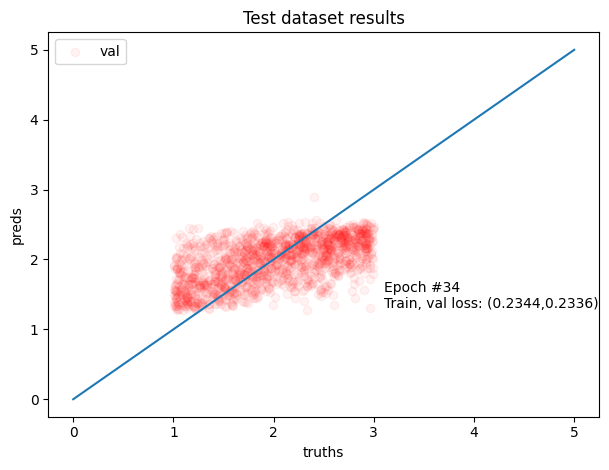

Test loss increased, adding uptick
Epoch 35/300 - Train loss:	 0.2307
Epoch 35/300 - Validation MSE:	 0.2399



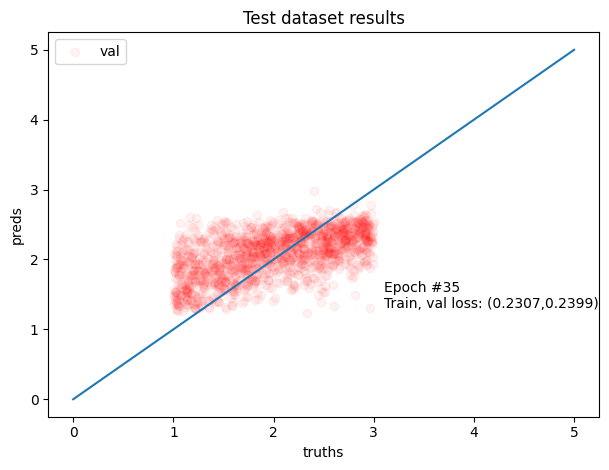

Test loss increased, adding uptick
Stopping early, loading current model...


/tmp/ipykernel_3360559/875346109.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopping_dict["best_model_path"]))


In [229]:
n_epochs = 300
early_stopping_limit = 5
trained_model, train_losses, val_losses, optimizer = train_GNN(model,optimizer,criterion, train_dataloader, val_dataloader, n_epochs, early_stopping_limit)

## **Plot training and val loss on log scale**

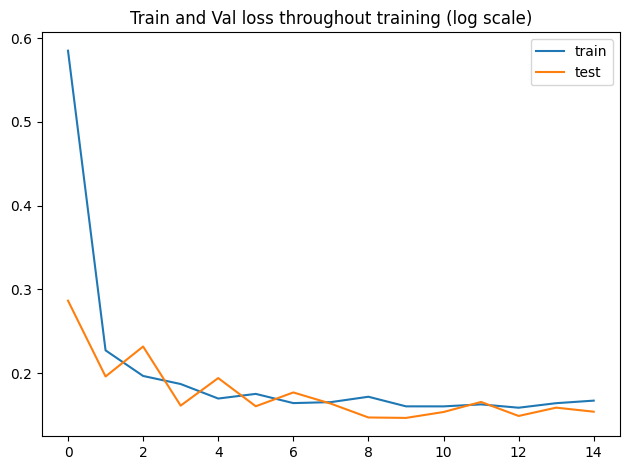

In [212]:
plot.plot(train_losses,label = "train")
plot.title("Train and Val loss throughout training (log scale)")
plot.plot(val_losses, label = "test")
# plot.yscale("log")
plot.legend()
plot.tight_layout()

## **Evaluate model on test dataset**

Now we can check the RMSE and across the whole test dataset and visualize the result

In [218]:
def test_GNN(model, test_dataloader):
    truths = []
    preds = []
    summed_sqe = 0.0
    num_predictions = 0
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                label = labels[i,0].item()
                pred = model(graph, graph.ndata["feat"].float()).detach().numpy()
                summed_sqe += pow(pred - label,2)
                num_predictions += 1

                preds.append(pred)
                truths.append(label)
    mse = summed_sqe / num_predictions
    print(f"MSE: {mse[0][0]}")
    return truths, preds

In [219]:
test_truths, test_preds = test_GNN(trained_model, test_dataloader)

plot.plot([0,5],[0,5])
plot.title("Test dataset results")
plot.scatter(test_truths,test_preds,alpha = 0.1)
plot.xlabel("truths")
plot.ylabel("preds")
plot.tight_layout()

TypeError: forward() missing 1 required positional argument: 'event_feats'

# Binned RMSE

In [77]:
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [78]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [79]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

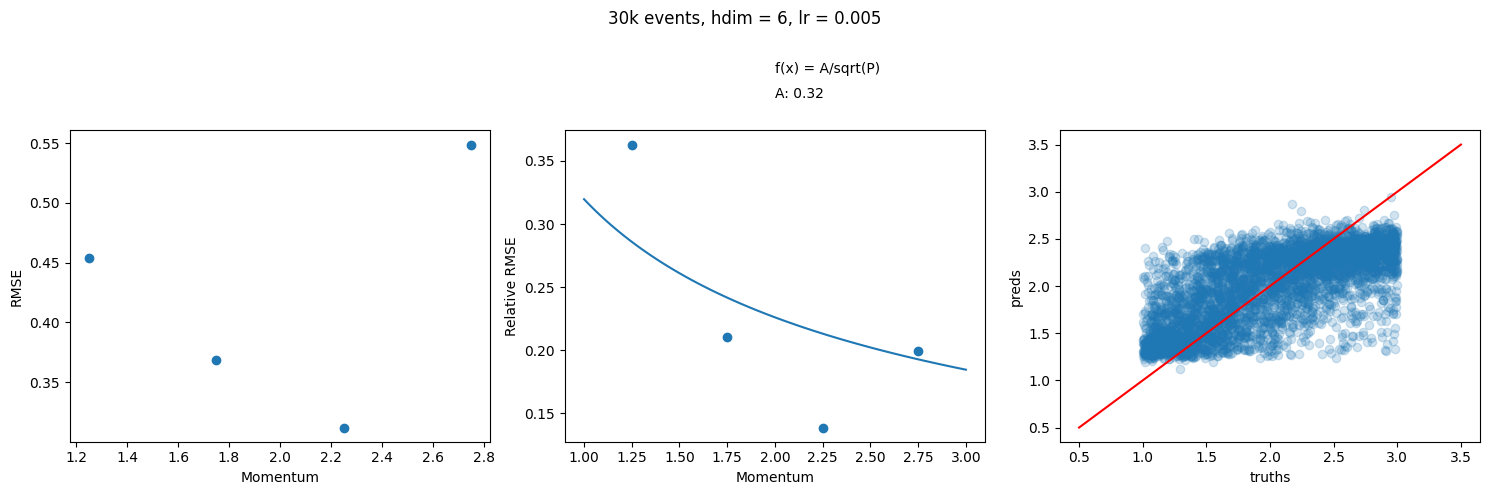

In [80]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("30k events, hdim = 6, lr = 0.005")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Momentum",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Momentum",ylabel = "Relative RMSE")
axs[1].text(2,0.4,f"A: {params[0]:.2f}")
axs[1].text(2,0.42,f"f(x) = A/sqrt(P)")
axs[2].scatter(test_truths,test_preds,alpha = 0.2)
axs[2].plot([0.5,3.5],[0.5,3.5],color = "red")
axs[2].set(xlabel = "truths",ylabel = "preds")
fig.tight_layout()
# plot.savefig(f"plots/GNN/run_{run_num}_RMSE_30kevents_hdim6_lr0_0005_GIN_geometry_2.pdf")